# <div style="padding: 30px;color:white;margin:10;font-size:100%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>Project |</span></b> <b>Emotional Sentiment Analysis and Adaptive Response System</b></div>

# <div style="padding: 30px;color:white;margin:10;font-size:100%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-color:rgb(120, 120, 199)"><b><span style='color:#F1A424'>Part 2 |</span></b> <b>Emotion Classification using Llama 3.2</b></div>

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>1 |</span></b> <b>INSTALL AND IMPORT REQUIRED LIBRARIES</b></div>

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from IPython.display import clear_output

!pip install peft==0.8.2
!pip install bitsandbytes==0.44.1
!pip install accelerate==0.34.2
!pip install datasets==2.16.1
!pip install GPUtil
!pip install transformers==4.43.1
clear_output()

In [2]:
!pip install contractions
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.4 MB/s eta 0:00:00


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")
secret_value_1 = user_secrets.get_secret("HF_TOKEN")
secret_value_2 = user_secrets.get_secret("KAGGLE")

In [4]:
#!pip install -U bitsandbytes==0.43.0

In [5]:
#!pip install -U transformers

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>2 |</span></b> <b>LOAD DATASET</b></div>

In [6]:
import warnings
import os
from transformers import set_seed
import numpy as np

SEED = 123
set_seed(SEED)

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

INPUT_DIR = '/kaggle/input/nlp-getting-started/'

DIR = '/kaggle/working/'

NUM_WORKERS = os.cpu_count()

EPOCHS, R, LORA_ALPHA, LORA_DROPOUT = 3,16,32,0.1
BATCH_SIZE = 8

MODEL_ID = '/kaggle/input/llama-3.2/transformers/1b/1'
# MODEL_ID = "/kaggle/input/llama-3.1/transformers/8b/2"

In [7]:
from datasets import load_dataset, load, Dataset, DatasetDict

# Dataset downloaded from HuggingFace
hf_dataset = load_dataset("dair-ai/emotion", download_mode="reuse_dataset_if_exists")


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>2 |</span></b> <b>PREPROCESS DATASET</b></div>

In [8]:
# in tweet people will mention or tag other, 
pattern_handle=r'@\w+'  # Only matched if @ followed by alphanumeric characters & underscore

# removing website, web url will not give information about sentiment or emotions
pattern_web =  r"(([\w]+:)?//)?(([\d\w]|%[a-fA-F\d]{2,2})+(:([\d\w]|%[a-fA-f\d]{2,2})+)?@)?([\d\w][-\d\w]{0,253}[\d\w]\.)+[\w]{2,4}(:[\d]+)?(/([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)*(\?(&?([-+_~.\d\w]|%[a-fA-f\d]{2,2})=?)*)?(#([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)?"

# removing email, email id will not give information about sentiment or emotions
pattern_email= r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"

# hastage in tweet, Ex: #LLM, #Love, #LLAMA
pattern_hash=r'#(\w+)'

# Removing some of the chars are repeated more than twice ex: oh my goddddddddddddd!, good, luckkkkkkkkkkkkk! 
pattern_repeat=r'([A-Za-z])\1{2,}'

# removing Contraction
# Removing Emoji


In [9]:
import re
import contractions
import emoji
import string

def clean_text(tweet):

    text_modified = re.sub(pattern_web,'',tweet)

    text_modified = re.sub(pattern_handle," ",text_modified)
    
    text_modified = re.sub(pattern_hash," \\1",text_modified)
    
    text_modified = re.sub(pattern_email,' ',text_modified)
    
    text_modified = emoji.demojize(text_modified)
    
    #Replacing ` with ' to be used in contraction
    pattern_apos = r'`'
    text_modified = re.sub(pattern_apos,"'",text_modified)

    #Removing contractions
    text_modified=contractions.fix(text_modified)

    #Normalising repeated characters
    text_modified=re.sub(pattern_repeat,r'\1',text_modified)
    
    #Removing numbers
    pattern_num=r'[0-9]'
    text_modified=re.sub(pattern_num," ",text_modified)
    
    #Removing punctuation
    pattern_punc="[" + re.escape(string.punctuation) + "]"
    
    text_modified=re.sub(pattern_punc," ",text_modified)
    
    #lowering characters
    text_modified=text_modified.lower()

    #Removing extra white space chars
    pattern_space=r'\s+'
    
    text_modified=re.sub(pattern_space," ",text_modified)
    
    return text_modified

## Visualize the Count of Label

In [10]:
# Apply cleaning function to the 'text' column
df_train = hf_dataset['train'].to_pandas()
df_test = hf_dataset['test'].to_pandas()
df_validate = hf_dataset['validation'].to_pandas()

<Axes: xlabel='label', ylabel='count'>

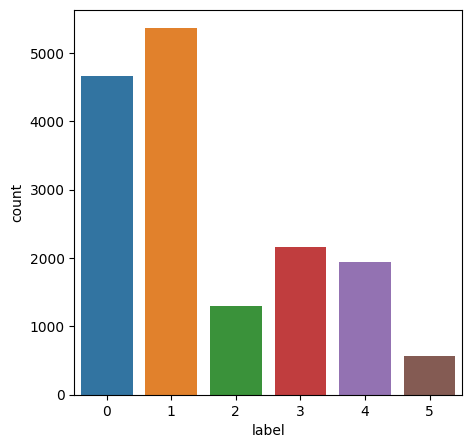

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
sns.countplot(df_train,x='label')

<Axes: xlabel='label', ylabel='count'>

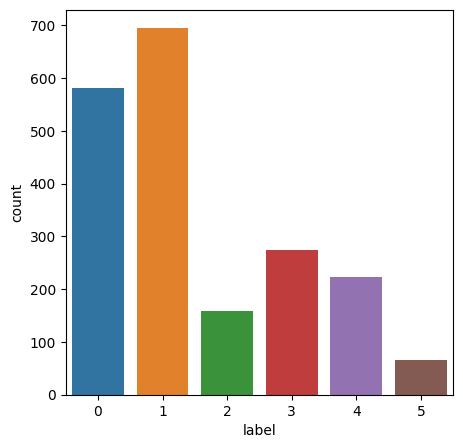

In [12]:
plt.figure(figsize=(5, 5))
sns.countplot(df_test,x='label')

<Axes: xlabel='label', ylabel='count'>

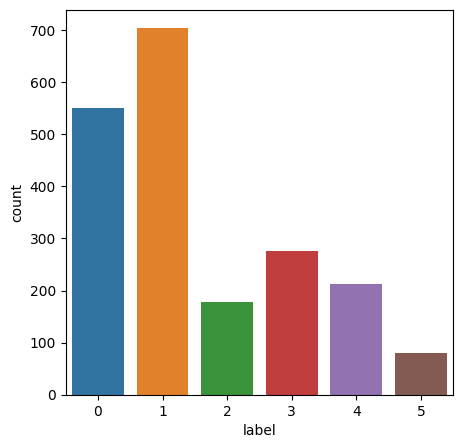

In [13]:
plt.figure(figsize=(5, 5))
sns.countplot(df_validate,x='label')

In [14]:
# Remove NaN in the dataset
df_train.dropna(how= 'any', axis=0, inplace=True)
df_test.dropna(how = 'any', axis=0, inplace=True)
df_validate.dropna(how = 'any', axis=0, inplace=True)

# Removing the empty string rows from Dataset
df_train = df_train[df_train['text'].str.strip() != ""]
df_test = df_test[df_test['text'].str.strip() != ""]
df_validate = df_validate[df_validate['text'].str.strip() != ""]


df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)
df_validate['cleaned_text'] = df_validate['text'].apply(clean_text)

In [15]:
# Dropping unwanted Column
df_train.drop(columns = ['text'], axis=1, inplace=True)
df_test.drop(columns = ['text'], axis=1, inplace=True)
df_validate.drop(columns = ['text'], axis=1, inplace=True)

# Rename column
df_train.rename(columns = {'cleaned_text': 'text'}, inplace=True)
df_test.rename(columns = {'cleaned_text': 'text'}, inplace=True)
df_validate.rename(columns = {'cleaned_text': 'text'}, inplace=True)

## Visualize the Count of Label with respect to the length of Text

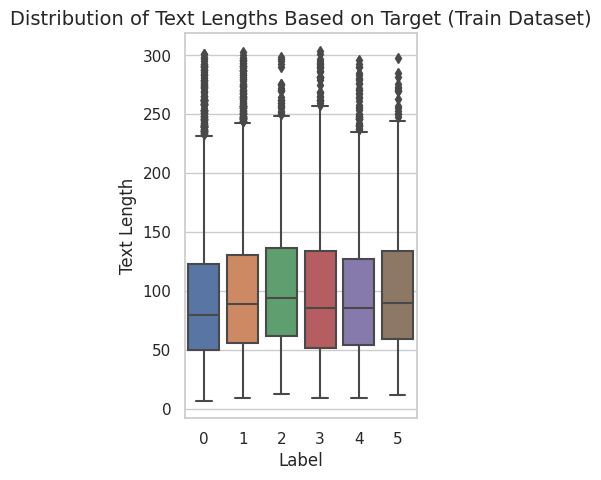

In [16]:
df = df_train.copy()
# Calculate the length of each string in the 'text' column
df['text_length'] = df['text'].apply(len)

# Set the style of the plot
sns.set(style="whitegrid")

# Visualize the length of strings based on the 'target' column using a boxplot
plt.figure(figsize=(3, 5))
sns.boxplot(x='label', y='text_length', data=df)

# Add title and labels
plt.title('Distribution of Text Lengths Based on Target (Train Dataset)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Text Length', fontsize=12)

# Show the plot
plt.show()


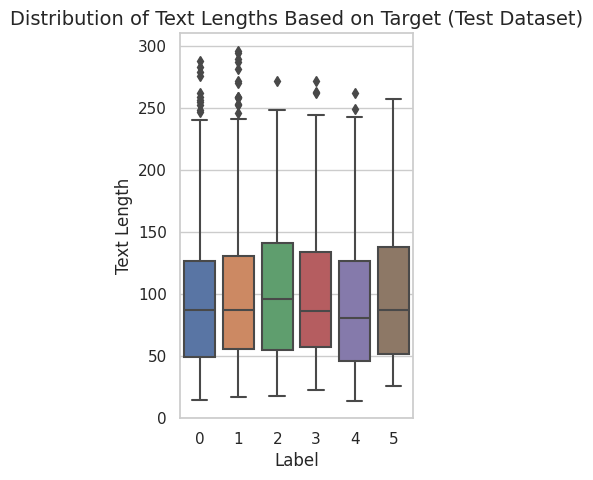

In [17]:
df = df_test.copy()
# Calculate the length of each string in the 'text' column
df['text_length'] = df['text'].apply(len)

# Set the style of the plot
sns.set(style="whitegrid")

# Visualize the length of strings based on the 'target' column using a boxplot
plt.figure(figsize=(3, 5))
sns.boxplot(x='label', y='text_length', data=df)

# Add title and labels
plt.title('Distribution of Text Lengths Based on Target (Test Dataset)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Text Length', fontsize=12)

# Show the plot
plt.show()


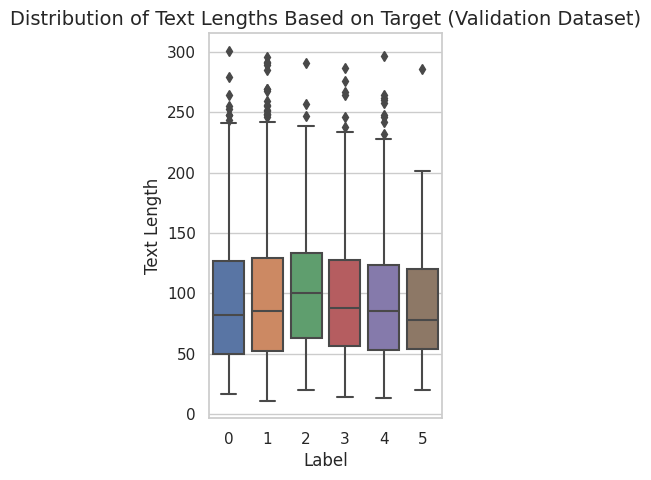

In [18]:
df = df_validate.copy()
# Calculate the length of each string in the 'text' column
df['text_length'] = df['text'].apply(len)

# Set the style of the plot
sns.set(style="whitegrid")

# Visualize the length of strings based on the 'target' column using a boxplot
plt.figure(figsize=(3, 5))
sns.boxplot(x='label', y='text_length', data=df)

# Add title and labels
plt.title('Distribution of Text Lengths Based on Target (Validation Dataset)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Text Length', fontsize=12)

# Show the plot
plt.show()


In [19]:
# Convert Pandas DataFrames to Hugging Face Datasets
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test),
    "validate": Dataset.from_pandas(df_validate),
})

In [20]:
print(dataset, dataset.keys())
dataset["train"][0], dataset['test'][0], dataset['train'][:5]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 2000
    })
    validate: Dataset({
        features: ['label', 'text'],
        num_rows: 2000
    })
}) dict_keys(['train', 'test', 'validate'])


({'label': 0, 'text': 'i did not feel humiliated'},
 {'label': 0,
  'text': 'i am feeling rather rotten so i am not very ambitious right now'},
 {'label': [0, 0, 3, 2, 3],
  'text': ['i did not feel humiliated',
   'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
   'i am grabbing a minute to post i feel greedy wrong',
   'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
   'i am feeling grouchy']})

In [21]:
dataset['train'].to_pandas()

,label,text
0,0,i did not feel humiliated
1,0,i can go from feeling so hopeless to so damned...
2,3,i am grabbing a minute to post i feel greedy w...
3,2,i am ever feeling nostalgic about the fireplac...
4,3,i am feeling grouchy
...,...,...
15995,0,i just had a very brief time in the beanbag an...
15996,0,i am now turning and i feel pathetic that i am...
15997,1,i feel strong and good overall
15998,3,i feel like this was such a rude comment and i...


In [22]:
from collections import Counter

train_len, test_len = len(dataset['train']), len(dataset['test'])
# train_len, test_len = 7000, 1500

train_dataset_label_counts = Counter(dataset['train']['label'])
test_dataset_label_counts = Counter(dataset['test']['label'])

print(f"Train dataset: {train_len} samples, {train_dataset_label_counts}")
print(f"Test dataset: {test_len} samples, {test_dataset_label_counts}")

test_majority_class = test_dataset_label_counts.most_common(1)[0]

baseline_accuracy = test_majority_class[1] / test_len

print(f"Baseline accuracy: {baseline_accuracy:.2%}")

Train dataset: 16000 samples, Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Test dataset: 2000 samples, Counter({1: 695, 0: 581, 3: 275, 4: 224, 2: 159, 5: 66})
Baseline accuracy: 34.75%


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>3 |</span></b> <b>TOKENIZE THE TEXT DATA</b></div>

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
print(tokenizer.padding_side, tokenizer.pad_token)
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer.padding_side, tokenizer.pad_token)

right None
right <|end_of_text|>


In [24]:
tokenized_dataset = {}

for split in dataset.keys():
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["text"], truncation=True), batched=True
    )
    

tokenized_dataset["train"], tokenized_dataset["test"]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

(Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 16000
 }),
 Dataset({
     features: ['label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 2000
 }))

In [25]:
NUM_CLASSES = len(set(dataset['train'].to_pandas()['label']))

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>4 |</span></b> <b>IMPORT PRETRAINED LLM MODAL (LLAMA 3.2 1B V1)</b></div>

In [26]:
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(  
    load_in_8bit= True,
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_CLASSES,
    quantization_config = bnb_config
)
print(model.config.pad_token_id)
model.config.pad_token_id = model.config.eos_token_id
print(model.config.pad_token_id)


`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.2/transformers/1b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


None
128001


In [27]:
print(model)

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear8bitLt(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear8bitLt(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear8bitLt(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear8bitLt(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
     

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>5 |</span></b> <b>Performance Efficient Tunning (PEFT) using Quantized Low Rank Adaptation (QLoRA) </b></div>

In [28]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

#model

In [29]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config = LoraConfig(
    r=R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    task_type=TaskType.SEQ_CLS,
    target_modules='all-linear'
)
#lora_config

In [30]:
lora_model = get_peft_model(model, lora_config)
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear8bitLt(
   

In [31]:
lora_model.print_trainable_parameters()

trainable params: 11,317,344 || all params: 1,247,176,896 || trainable%: 0.9074369511091392


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>6 |</span></b> <b>Train and Evaluation of LLM</b></div>

In [32]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}
"""
trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="./data/",
        learning_rate=2e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=True,
        logging_steps=10,
        report_to="none"
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
"""

'\ntrainer = Trainer(\n    model=lora_model,\n    args=TrainingArguments(\n        output_dir="./data/",\n        learning_rate=2e-5,\n        per_device_train_batch_size=BATCH_SIZE,\n        per_device_eval_batch_size=BATCH_SIZE,\n        evaluation_strategy="epoch",\n        save_strategy="epoch",\n        num_train_epochs=EPOCHS,\n        weight_decay=0.01,\n        load_best_model_at_end=True,\n        logging_steps=10,\n        report_to="none"\n    ),\n    train_dataset=tokenized_dataset["train"],\n    eval_dataset=tokenized_dataset["test"],\n    tokenizer=tokenizer,\n    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),\n    compute_metrics=compute_metrics,\n)\n'

In [33]:
trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="./data/",
        learning_rate=2e-5,  # Start with 2e-5, try other values in a range
        per_device_train_batch_size=16,  # Larger batch size if memory permits
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",  # You can change to "steps" if you want more frequent evals
        save_strategy="epoch",  # Save after every epoch
        save_total_limit=3,  # Limit the number of saved checkpoints to avoid excessive storage use
        num_train_epochs=EPOCHS,  # Adjust based on validation loss curve
        weight_decay=0.01,
        load_best_model_at_end=True,
        logging_steps=100,  # Log less frequently if training is long
        report_to="tensorboard",  # Useful for monitoring training progress
        fp16=False,  # Enable mixed-precision training (if hardware supports it)
        lr_scheduler_type="linear",  # Linear decay of learning rate
        dataloader_num_workers=4,  # Optimize data loading, adjust based on your CPU
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)


In [34]:
print("Evaluating the Model Before Training!")
trainer.evaluate()

Evaluating the Model Before Training!


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


{'eval_loss': 4.001168727874756,
 'eval_model_preparation_time': 0.004,
 'eval_accuracy': 0.047,
 'eval_runtime': 43.0017,
 'eval_samples_per_second': 46.51,
 'eval_steps_per_second': 2.907}

In [35]:
print("Training the Model")
trainer.train()

Training the Model


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.250400,0.228375,0.004000,0.914000
2,0.133700,0.189745,0.004000,0.927000
3,0.085400,0.184022,0.004000,0.929000


TrainOutput(global_step=3000, training_loss=0.29749103609720867, metrics={'train_runtime': 3080.5677, 'train_samples_per_second': 15.582, 'train_steps_per_second': 0.974, 'total_flos': 1.2712542223454208e+16, 'train_loss': 0.29749103609720867, 'epoch': 3.0})

In [36]:
print("Evaluating the trained model")
trainer.evaluate()

Evaluating the trained model


{'eval_loss': 0.18281733989715576,
 'eval_model_preparation_time': 0.004,
 'eval_accuracy': 0.929,
 'eval_runtime': 41.0887,
 'eval_samples_per_second': 48.675,
 'eval_steps_per_second': 3.042,
 'epoch': 3.0}

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>7 |</span></b> <b>Saving the Fine-Tuned Model for Future Use</b></div>

In [37]:
print("Saving the model!")
lora_model.save_pretrained('fine-tuned-model')
# tokenizer.save_pretrained('fine-tuned-model1')

Saving the model!


In [38]:
import subprocess

# Retrieve token from environment variable
hf_token = secret_value_1

if hf_token:
    # Automate Hugging Face CLI login
    subprocess.run(
        ["huggingface-cli", "login", "--token", hf_token],
        check=True
    )
    print("Logged in to Hugging Face successfully!")
else:
    print("HF_TOKEN environment variable is not set.")

Logged in to Hugging Face successfully!


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `Master-ACCESS` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Master-ACCESS`


In [39]:
repo_name = 'jayachandru001/Llama-3.2-1B-for-Emotion-clf-v1'
lora_model.push_to_hub(repo_name, use_auth_token=True, force=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jayachandru001/Llama-3.2-1B-for-Emotion-clf-v1/commit/2a580e693056ef3bd6cc6a63cbaf76456342dbfb', commit_message='Upload model', commit_description='', oid='2a580e693056ef3bd6cc6a63cbaf76456342dbfb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jayachandru001/Llama-3.2-1B-for-Emotion-clf-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='jayachandru001/Llama-3.2-1B-for-Emotion-clf-v1'), pr_revision=None, pr_num=None)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>8 |</span></b> <b>Testing the Fine-Tuned Model</b></div>

In [40]:
from transformers import pipeline

clf = pipeline("text-classification", lora_model, tokenizer=MODEL_ID)

The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification'

In [41]:
dataset['validate'].to_pandas()

,label,text
0,0,i am feeling quite sad and sorry for myself bu...
1,0,i feel like i am still looking at a blank canv...
2,2,i feel like a faithful servant
3,3,i am just feeling cranky and blue
4,1,i can have for a treat or if i am feeling festive
...,...,...
1995,0,i am having ssa examination tomorrow in the mo...
1996,1,i constantly worry about their fight against n...
1997,1,i feel its important to share this info for th...
1998,1,i truly feel that if you are passionate enough...


In [42]:
prediction1 = clf("it so hard solve the programming question")
prediction = int(prediction1[0]['label'].split('_')[1])
print(prediction)

3


## Batch Prediction

In [43]:
dataset_validate = Dataset.from_pandas(df_validate)

# Batch prediction function
def batch_predict(batch):
    predictions = clf(batch["text"])  # Apply classifier to batch of texts
    batch["prediction"] = [int(pred["label"].split("_")[1]) for pred in predictions]  # Extract numeric labels
    return batch

# Apply the batch prediction function to the dataset
result_dataset = dataset_validate.map(batch_predict, batched=True, batch_size=32)  # Adjust batch_size as needed

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [44]:
df_valid = result_dataset.to_pandas()

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>9 |</span></b>Analysing the Test Results using Confusion Matrix<b></b></div>

Accuracy: 93.70%

Confusion Matrix:
[[530   1   0   8  11   0]
 [  1 680  20   1   1   1]
 [  0  22 155   1   0   0]
 [  9   3   1 253   9   0]
 [  7   2   0   8 193   2]
 [  2   3   2   0  11  63]]


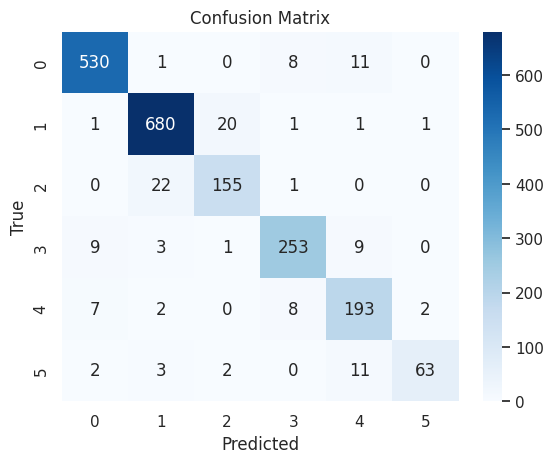


Classification Report:
              precision    recall  f1-score   support

         sad       0.97      0.96      0.96       550
         joy       0.96      0.97      0.96       704
        love       0.87      0.87      0.87       178
       anger       0.93      0.92      0.93       275
        fear       0.86      0.91      0.88       212
    surprise       0.95      0.78      0.86        81

    accuracy                           0.94      2000
   macro avg       0.92      0.90      0.91      2000
weighted avg       0.94      0.94      0.94      2000



In [45]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# 1. **Calculate Accuracy**
accuracy = accuracy_score(df_valid['label'], df_valid['prediction'])
print(f"Accuracy: {accuracy * 100:.2f}%")

# 2. **Confusion Matrix**
cm = confusion_matrix(df_valid['label'], df_valid['prediction'])
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix with a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 3. **Classification Report**
report = classification_report(df_valid['label'], df_valid['prediction'], target_names=['sad', 'joy', 'love', 'anger', 'fear', 'surprise'])
print("\nClassification Report:")
print(report)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>10 |</span></b> Loading the Saved Model From Hugging Face<b></b></div>

In [46]:
!pip install huggingface

In [47]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")
secret_value_1 = user_secrets.get_secret("HF_TOKEN")
secret_value_2 = user_secrets.get_secret("KAGGLE")

In [48]:
import subprocess

# Retrieve token from environment variable
hf_token = secret_value_1

if hf_token:
    # Automate Hugging Face CLI login
    subprocess.run(
        ["huggingface-cli", "login", "--token", hf_token],
        check=True
    )
    print("Logged in to Hugging Face successfully!")
else:
    print("HF_TOKEN environment variable is not set.")

Logged in to Hugging Face successfully!


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `Master-ACCESS` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Master-ACCESS`


In [49]:
!pip install -U peft==0.8.2

In [50]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
from transformers import pipeline

EMO_NUM_CLASSES = 6

base_model_path = '/kaggle/input/llama-3.2/transformers/1b/1'
loaded_tokenizer = AutoTokenizer.from_pretrained(base_model_path)
loaded_base_model_emotion = AutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=EMO_NUM_CLASSES,)

from peft import PeftModel, PeftConfig

adapter_path1 = "jayachandru001/Llama-3.2-1B-for-Emotion-clf-v1"

# Load the adapter configuration
# peft_config = PeftConfig.from_pretrained(adapter_path1)

# Attach the adapter to the base model
emotionClf = PeftModel.from_pretrained(loaded_base_model_emotion, adapter_path1)

# Verify the loaded model
# print(loaded_model)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.2/transformers/1b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.6M [00:00<?, ?B/s]

In [51]:
SEN_NUM_CLASSES = 3

loaded_base_model_sentiment = AutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=SEN_NUM_CLASSES,)

adapter_path2 = "jayachandru001/sentiment_classification_using_llama_3.2_1B_V2"

# Load the adapter configuration
# peft_config = PeftConfig.from_pretrained(adapter_path2)

# Attach the adapter to the base model
sentimentClf = PeftModel.from_pretrained(loaded_base_model_sentiment, adapter_path2)

# Verify the loaded model
# print(loaded_model)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.2/transformers/1b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

In [52]:
from transformers import pipeline

sentiment_clf = pipeline("text-classification", sentimentClf, tokenizer=loaded_tokenizer)
emotion_clf = pipeline("text-classification", emotionClf, tokenizer=loaded_tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassifi

In [53]:
input_text = "I feeling down today"# input()
print(sentiment_clf(input_text))
print(emotion_clf(input_text))


[{'label': 'LABEL_2', 'score': 0.9940859079360962}]
[{'label': 'LABEL_0', 'score': 0.9999784231185913}]


In [54]:
import os
import google.generativeai as genai

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")
secret_value_1 = user_secrets.get_secret("HF_TOKEN")


# Configure the generative AI model with the API key
genai.configure(api_key= secret_value_0)

generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 256,
  "response_mime_type": "text/plain",
}

# Initialize the generative model
model = genai.GenerativeModel("gemini-1.5-flash",
                              generation_config=generation_config,
                              system_instruction = """You are an advanced AI designed to generate empathetic 
                              responses based on the emotional state of the user, which has been classified by 
                              a separate emotional classification model. Your task is to generate a supportive, 
                              contextually appropriate response that aligns with the identified emotion, offering 
                              comfort, validation, and empathy.""")
chat = model.start_chat(history=[])

In [55]:
"""
id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
user_input = input("YOU :")

predLabel = emotion_clf(user_input)
predEmotion = int(predLabel[0]['label'].split('_')[1])
print(id2label[predEmotion])


emotion = f"Emotion: [{id2label[predEmotion]}]"
#emotion = "Emotion: [neutral]"
user_input_emotion = user_input+ " " +emotion

response = chat.send_message(user_input_emotion)
temp_response = ""
for chunk in response:
    temp_response += chunk.text
print("AI :",temp_response)
"""

'\nid2label = {\n    0: "sadness",\n    1: "joy",\n    2: "love",\n    3: "anger",\n    4: "fear",\n    5: "surprise"\n}\nuser_input = input("YOU :")\n\npredLabel = emotion_clf(user_input)\npredEmotion = int(predLabel[0][\'label\'].split(\'_\')[1])\nprint(id2label[predEmotion])\n\n\nemotion = f"Emotion: [{id2label[predEmotion]}]"\n#emotion = "Emotion: [neutral]"\nuser_input_emotion = user_input+ " " +emotion\n\nresponse = chat.send_message(user_input_emotion)\ntemp_response = ""\nfor chunk in response:\n    temp_response += chunk.text\nprint("AI :",temp_response)\n'

In [56]:
label2id = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}


id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}



# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>11 |</span></b> Code for Running the Empathetic AI ChatBot in Cloud using Gradio<b></b></div>

<div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb">
  <b><span style='color:#F1A424'>🚀</span></b> 
  <b>Ready to Experience the AI Conversations?</b><br>
  🔮 <b>Click here to ask your own Empathetic AI Chatbot in the Cloud!</b> 🌐<br>
  💬 <b>Get personalized, compassionate responses in real-time with Gradio.</b> 🔥<br><br>
  <a href="https://huggingface.co/spaces/jayachandru001/Empathetic-AI-Bot" style="color:white;text-decoration:none;font-size:18px;font-weight:bold;background-color:#F1A424;padding:10px 20px;border-radius:5px;">Launch Your AI Bot Now!</a>
</div>


In [57]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.111.0
    U

In [58]:
!pip install -U peft==0.8.2

In [59]:
import gradio as gr
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
from transformers import pipeline
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# Constants for the number of classes
EMO_NUM_CLASSES = 6
SEN_NUM_CLASSES = 3

# Load the tokenizer and base model for emotion classification and sentiment classification
base_model_path = '/kaggle/input/llama-3.2/transformers/1b/1'
loaded_tokenizer = AutoTokenizer.from_pretrained(base_model_path)

# Emotion classification model
loaded_base_model_emotion = AutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=EMO_NUM_CLASSES)
adapter_path1 = "jayachandru001/Llama-3.2-1B-for-Emotion-clf-v1"
emotionClf = PeftModel.from_pretrained(loaded_base_model_emotion, adapter_path1)

# Sentiment classification model
loaded_base_model_sentiment = AutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=SEN_NUM_CLASSES)
adapter_path2 = "jayachandru001/sentiment_classification_using_llama_3.2_1B_V2"
sentimentClf = PeftModel.from_pretrained(loaded_base_model_sentiment, adapter_path2)

# Load the Hugging Face pipelines
sentiment_clf = pipeline("text-classification", sentimentClf, tokenizer=loaded_tokenizer)
emotion_clf = pipeline("text-classification", emotionClf, tokenizer=loaded_tokenizer)

# Configure the generative AI model with the API key
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")
secret_value_1 = user_secrets.get_secret("HF_TOKEN")
genai.configure(api_key=secret_value_0)

# Initialize the generative model
generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 64,
    "max_output_tokens": 256,
    "response_mime_type": "text/plain",
}

model = genai.GenerativeModel("gemini-1.5-flash", generation_config=generation_config,
                              system_instruction="""You are an advanced AI designed to generate empathetic 
                              responses based on the emotional state of the user, which has been classified by 
                              a separate emotional classification model. Your task is to generate a supportive, 
                              contextually appropriate response that aligns with the identified emotion, offering 
                              comfort, validation, and empathy.""")

# Emotion labels
emotion_id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Sentiment labels
sentiment_id2label = {
    0: "neutral",
    1: "positive",
    2: "negative",
}

# Function to handle the chatbot's conversation logic
def chat_with_user(user_message, history):
    # Get sentiment prediction
    sentiment_result = sentiment_clf(user_message)
    pred_sentiment = int(sentiment_result[0]['label'].split('_')[1])
    sentiment = sentiment_id2label[pred_sentiment]

    emotion = ""
    # If the sentiment is not neutral, predict emotion
    if pred_sentiment != 0:
        # Get emotion prediction
        pred_label = emotion_clf(user_message)
        pred_emotion = int(pred_label[0]['label'].split('_')[1])
        # Map the prediction to the emotion label
        emotion = emotion_id2label[pred_emotion]

    # Prepare the user's message with detected sentiment and emotion, each on a new line
    user_input_emotion = f"{user_message}\nSentiment: [{sentiment}]\nEmotion: [{emotion}]"

    # Generate the empathetic response from Gemini
    chat = model.start_chat(history=[])
    response = chat.send_message(user_input_emotion)
    temp_response = ""
    for chunk in response:
        temp_response += chunk.text
    
    # Return sentiment, emotion, and the AI's empathetic response
    history.append((
        f"User: {user_message}\nSentiment: [{sentiment}]\nEmotion: [{emotion}]",
        f"Bot: {temp_response}"
    ))
    return "", history


# Define the interface components with Gradio
with gr.Blocks() as demo:
    gr.Markdown("# Chat with Empathetic AI Bot")

    # Chatbot container (left = user, right = bot)
    chat = gr.Chatbot()

    # Textbox for user input at the bottom of the screen
    textbox = gr.Textbox(placeholder="Type a message...", show_label=False)

    # Submit button and action to handle message
    textbox.submit(chat_with_user, inputs=[textbox, chat], outputs=[textbox, chat])

    # Inject custom CSS directly via gr.HTML
    gr.HTML("""
    <style>
        .chatbot {
            max-height: 80vh;
            overflow-y: auto;
            display: flex;
            flex-direction: column;
            justify-content: flex-end;
        }

        .chatbot .message:nth-child(odd) { 
            text-align: left; 
            background-color: #e1f5fe; 
            border-radius: 5px;
            padding: 10px;
            margin: 5px;
        }

        .chatbot .message:nth-child(even) { 
            text-align: right; 
            background-color: #f1f8e9; 
            border-radius: 5px;
            padding: 10px;
            margin: 5px;
        }

        .gradio-container {
            display: flex;
            flex-direction: column;
            height: 100vh;
        }

        .gradio-input {
            position: fixed;
            bottom: 20px;
            left: 10%;
            right: 10%;
            width: 80%;
        }
    </style>
    """)

    # Inject custom JavaScript to automatically scroll to the bottom when a new message is added
    gr.HTML("""
    <script>
        const chatbot = document.querySelector('.chatbot');
        const inputBox = document.querySelector('.gradio-input input');

        // Scroll to the bottom of the chat after each update
        function scrollToBottom() {
            chatbot.scrollTop = chatbot.scrollHeight;
        }

        // Listen for any new message updates
        const observer = new MutationObserver(scrollToBottom);
        observer.observe(chatbot, { childList: true });

        // Initial scroll position when the page loads
        window.onload = scrollToBottom;

        // Ensure that input field is at the bottom of the page
        inputBox.addEventListener('focus', () => {
            setTimeout(scrollToBottom, 100);
        });
    </script>
    """)

# Launch the Gradio app
demo.launch()


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.2/transformers/1b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.2/transformers/1b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusFor

* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ddb2bb2a94e2ffa0b3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
